# Physical Activity Prediction

## Team (M2 Data Science - IP Paris):
 - **Abed El Kader EL SHAAR**
 - **Ahmad AL MASRI**
 - **Ahmad KHALIFE**
 - **Hadi JABER**
 - **Karen KHOURY**
 - **Sara GHAMLMOUSH**

In [12]:
import os
import tarfile

def recursive_files(dir_name='.', ignore=None):
    for dir_name,subdirs,files in os.walk(dir_name):
        if ignore and os.path.basename(dir_name) in ignore: 
            continue

        for file_name in files:
            if ignore and file_name in ignore:
                continue

            yield os.path.join(dir_name, file_name)

def make_tar_file(dir_name='.', tar_file_name='tarfile.tar', ignore=None):
    tar = tarfile.open(tar_file_name, 'w')

    for file_name in recursive_files(dir_name, ignore):
        tar.add(file_name)

    tar.close()


dir_name = '.'
tar_file_name = 'DatacampGroup.tar'
ignore = {'.ipynb_checkpoints', '__pycache__', tar_file_name}
make_tar_file(dir_name, tar_file_name, ignore)

### Introduction

Physical activity plays an important role in controlling obesity and maintaining a healthy living. It becomes increasingly important during a pandemic due to restrictions on outdoor activities.
Tracking physical activities using miniature wearable sensors and state-of-the-art machine learning
techniques can encourage healthy living and control obesity. 

This project focuses on introducing novel techniques to identify and log physical activities using machine learning techniques and wearable sensors. Physical activities performed in daily life are often unstructured and unplanned, and one
activity or set of activities (sitting, standing) might be more frequent than others (walking, stairs
up, stairs down).

The dataset used is [PAMAP2](https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring) which is an Activity Monitoring dataset that covers 18 different physical activities done by 9 different subjects (8 men and 1 woman), recorded using 3 inertial measurement units and a heart rate monitor.

The outcome of this project should be to be able to classify activities based on the different sensors readings, and thus gain insights on what muscles are used to do different activities and what activities might be easier or more common than others.

### Getting the data

To get the data, simply invoke download_data.py as follow:

In [1]:
%run download_data.py

Extracting data...
Done


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Preparations done on the data

We have prepared our data in such a way that:
- The public training data consists of activities performed by subjects : 1, 2, 3, 4, 9
- The public testing data consists of activities performed by subjects : 6, 7
- The private data (hidden from the user) consists of activites performed by subject : 8

The evaluation metrics will be based on the negative log loss and the accuracy, we will measure these metrics using a LeaveOneGroupOut crossvalidation where at each fold we train on all subjects except for one.

### Inspecting the data

In [3]:
from problem import get_train_data

data_train, labels_train = get_train_data()

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197898 entries, 0 to 1197897
Data columns (total 54 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp          1197898 non-null  float64
 1   heartrate          1197898 non-null  float64
 2   handTemperature    1197898 non-null  float64
 3   handAcc16_1        1197898 non-null  float64
 4   handAcc16_2        1197898 non-null  float64
 5   handAcc16_3        1197898 non-null  float64
 6   handAcc6_1         1197898 non-null  float64
 7   handAcc6_2         1197898 non-null  float64
 8   handAcc6_3         1197898 non-null  float64
 9   handGyro1          1197898 non-null  float64
 10  handGyro2          1197898 non-null  float64
 11  handGyro3          1197898 non-null  float64
 12  handMagne1         1197898 non-null  float64
 13  handMagne2         1197898 non-null  float64
 14  handMagne3         1197898 non-null  float64
 15  handOrientation1   1197898 non-n

An IMU sensor was used to capture measurements related to the hand, chest and ankle.
For instance : 

- 1 : hand temperature (°C)
- 2-4 : hand 3D-acceleration data (ms-2), scale: ±16g, resolution: 13-bit
- 5-7 : hand 3D-acceleration data (ms-2), scale: ±6g, resolution: 13-bit*
- 8-10 : hand 3D-gyroscope data (rad/s)
- 11-13 : hand 3D-magnetometer data (μT)
- 14-17 : hand orientation (invalid in this data collection)

## Exploratory Data Analysis

In [5]:
data_train['heartrate'].describe()

count    1.197898e+06
mean     1.100257e+02
std      2.573248e+01
min      5.700000e+01
25%      8.900000e+01
50%      1.090000e+02
75%      1.260000e+02
max      1.830000e+02
Name: heartrate, dtype: float64

We can see a big difference between the min and max value of Heartrates, those may be outliers, or just the idea that Heartrate differs vastly between different activities .

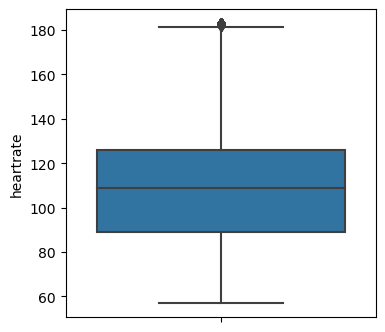

In [6]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(4,4))
ax = sns.boxplot(y=data_train["heartrate"]);

Looking at the box plot, we can see that values bigger than 180 are classified as outliers. <br>
To find the most cumbersome activities we can plot a bar chart showing the mean values of heart rates for each activity:

<AxesSubplot:xlabel='activityID'>

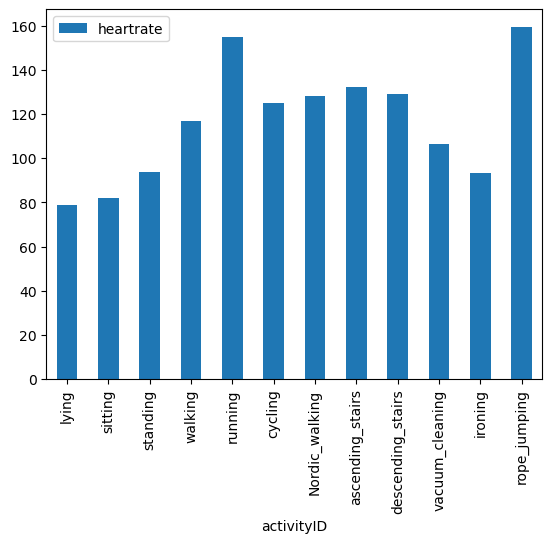

In [7]:
concat_data = pd.concat([data_train,pd.DataFrame(labels_train, columns =['activityID'])],axis = 1)
df_grp = concat_data.groupby('activityID').agg({'heartrate': 'mean'})
df_grp.index = df_grp.index.map(activityIDdict)
df_grp.plot(kind='bar')

The bar chart shows that Rope Jumping and Running are the most cumbersome activities out of all the activities, and those might be the reason some heartrates are above 180 (and thus not outliers).

#### Checking if the data is balanced

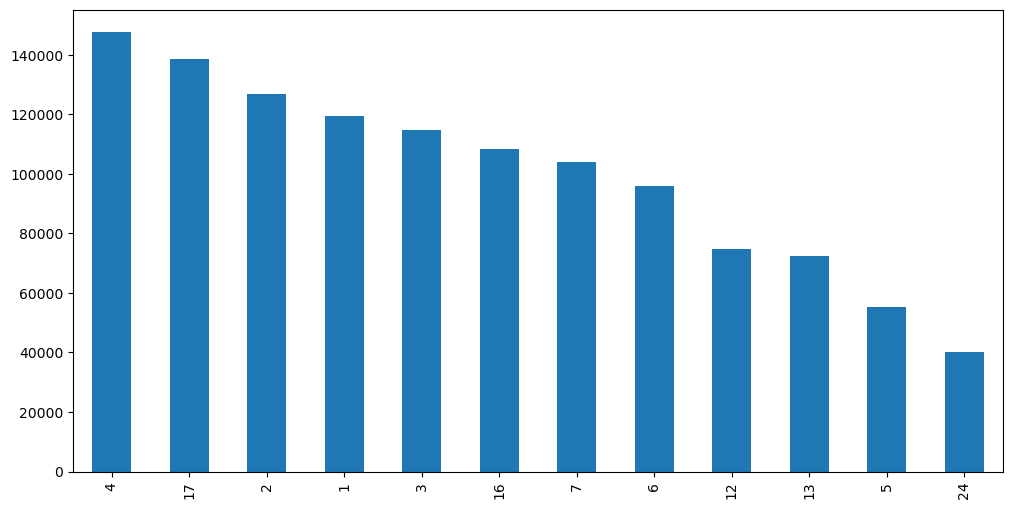

In [8]:
concat_data['activityID'].value_counts().plot(kind = "bar",figsize = (12,6))
plt.show()

As the above plot shows, classes are mostly balanced, with activity 24 being the least exercised.<br>

### Ramp test

In [9]:
!ramp-test --submission starting_kit

Testing Physical Activity Prediction
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
/home/infres/aalmasri-21/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
	score   nll   acc       time
	train  0.87  0.79  43.686052
	valid  1.27  0.60   0.661851
	test   0.66  0.79   0.339510
CV fold 1
/home/infres/aalmasri-21/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACH